# Metagraph and Metapath Generation

Here, we use the same syntax as [HetNetPy](https://github.com/hetio/hetnetpy/tree/e1ff1f8296b766dd5a63e5870a8a1a7d82427a80) to create a metagraph and extract metapaths from the KG.

Metagraph creation is based on [this notebook](https://github.com/dhimmel/integrate/blob/93feba1765fbcd76fd79e22f25121f5399629148/integrate.ipynb).

In [1]:
import pandas as pd
import seaborn as sns
import os.path as osp
import os

import hetnetpy.hetnet
import hetnetpy.readwrite
import hetnetpy.stats

from hetnetpy.abbreviation import metaedges_from_metapath
import re
import json
from collections import Counter

%matplotlib inline

### Define and Instantiate Metagraph:

In [2]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Gene': 'G',
    'Biological Process': 'BP',
    
    # metaedges
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'participates': 'p',
    'induces': 't',
}

metaedge_tuples = [
    ('Compound', 'Gene', 'upregulates', 'forward'),
    ('Compound', 'Gene', 'downregulates', 'forward'),
    ('Gene', 'Gene', 'interacts', 'forward'),
    ('Gene', 'Biological Process', 'participates', 'forward'),
    ('Compound', 'Biological Process', 'induces', 'forward')
]

metagraph = hetnetpy.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetnetpy.hetnet.Graph(metagraph)

In [3]:
KG_DIR = '../data/kg/'
SPLITS_DIR = osp.join(KG_DIR, 'splits')
MOA_NET_DIR = osp.join(SPLITS_DIR, 'MoA-net')
MARS_DIR = osp.join(MOA_NET_DIR, 'MARS')

for dir in [KG_DIR, SPLITS_DIR, MOA_NET_DIR, MARS_DIR]:
    if not osp.exists(dir):
        os.makedirs(dir)

kg = pd.read_csv(osp.join(MOA_NET_DIR, 'kg_no_cmp_bp.tsv'), sep='\t')

In [4]:
# show me the duplicated rows in the dataframe
kg[kg.duplicated(keep=False)]

,source,source_node_type,target,target_node_type,edge_type


In [5]:
kg.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
94942    False
94943    False
94944    False
94945    False
94946    False
Length: 94947, dtype: bool

In [6]:
kg.head()

,source,source_node_type,target,target_node_type,edge_type
0,pubchem.compound:10607,Compound,ncbigene:3553,Gene,upregulates
1,pubchem.compound:10607,Compound,ncbigene:203068,Gene,downregulates
2,pubchem.compound:10607,Compound,ncbigene:54658,Gene,downregulates
3,pubchem.compound:10607,Compound,ncbigene:7153,Gene,downregulates
4,pubchem.compound:10607,Compound,ncbigene:7277,Gene,downregulates


In [7]:
seen = set()

for i, row in kg.iterrows():
    if not row['source'] in seen:
        graph.add_node(kind=row['source_node_type'], identifier=row['source'])
        seen.add(row['source'])
    if not row['target'] in seen:
        graph.add_node(kind=row['target_node_type'], identifier=row['target'])
        seen.add(row['target'])

    src_id = row['source_node_type'], row['source']
    trgt_id = row['target_node_type'], row['target']

    graph.add_edge(source_id=src_id, target_id=trgt_id, kind=row['edge_type'], direction='forward')

## Network Visualization and Stats

In [8]:
metanode_df = hetnetpy.stats.get_metanode_df(graph)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
2,Biological Process,BP,2,86,0
0,Compound,C,3,300,0
1,Gene,G,4,9301,0


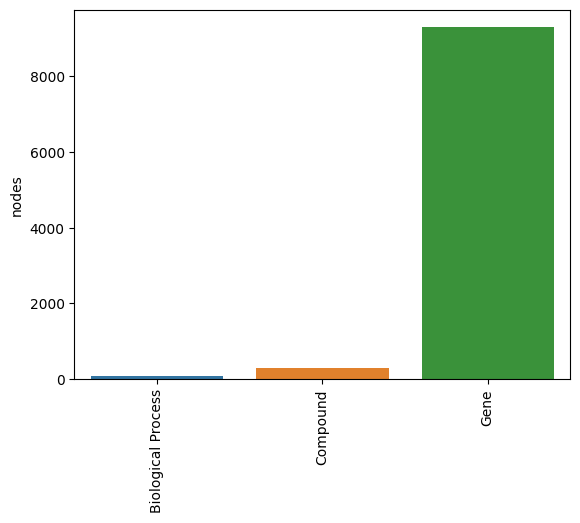

In [9]:
ax = sns.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

In [10]:
# Total number of nodes
metanode_df.nodes.sum()

9687

In [11]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetnetpy.stats.get_metaedge_df(graph)

metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes
1,Compound > downregulates > Gene,Cd>G,2205,271,916
4,Compound > induces > Biological Process,Ct>BP,0,0,0
0,Compound > upregulates > Gene,Cu>G,1631,184,865
2,Gene > interacts > Gene,Gi>G,86786,5240,8578
3,Gene > participates > Biological Process,Gp>BP,4325,3159,86


In [12]:
metaedge_df.to_excel('../paper_materials/metaedge_df.xlsx')

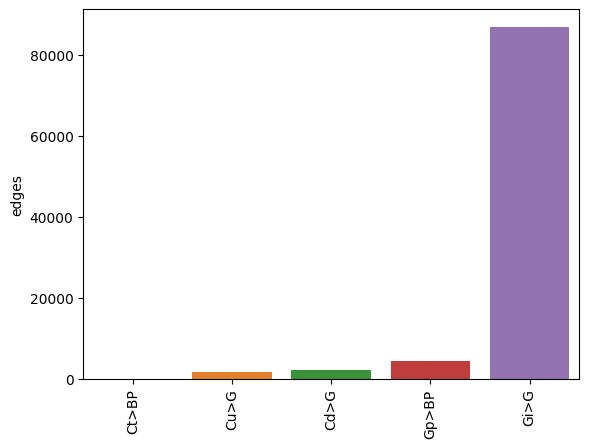

In [13]:
ax = sns.barplot(x='abbreviation', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');

In [14]:
# Summary of different styles for representing each metaedge
metaedge_style_df = hetnetpy.stats.get_metaedge_style_df(metagraph)
metaedge_style_df

,metaedge,unicode_metaedge,standard_metaedge,abbreviation,standard_abbreviation,source,target,inverted
9,Biological Process < induces < Compound,Biological Process←induces←Compound,Compound > induces > Biological Process,BP<tC,CtBP,Biological Process,Compound,1
7,Biological Process < participates < Gene,Biological Process←participates←Gene,Gene > participates > Biological Process,BP<pG,GpBP,Biological Process,Gene,1
2,Compound > downregulates > Gene,Compound→downregulates→Gene,Compound > downregulates > Gene,Cd>G,CdG,Compound,Gene,0
8,Compound > induces > Biological Process,Compound→induces→Biological Process,Compound > induces > Biological Process,Ct>BP,CtBP,Compound,Biological Process,0
0,Compound > upregulates > Gene,Compound→upregulates→Gene,Compound > upregulates > Gene,Cu>G,CuG,Compound,Gene,0
3,Gene < downregulates < Compound,Gene←downregulates←Compound,Compound > downregulates > Gene,G<dC,CdG,Gene,Compound,1
5,Gene < interacts < Gene,Gene←interacts←Gene,Gene > interacts > Gene,G<iG,GiG,Gene,Gene,1
1,Gene < upregulates < Compound,Gene←upregulates←Compound,Compound > upregulates > Gene,G<uC,CuG,Gene,Compound,1
4,Gene > interacts > Gene,Gene→interacts→Gene,Gene > interacts > Gene,Gi>G,GiG,Gene,Gene,0
6,Gene > participates > Biological Process,Gene→participates→Biological Process,Gene > participates > Biological Process,Gp>BP,GpBP,Gene,Biological Process,0


In [15]:
# Number of edges in the network
metaedge_df.edges.sum()

94947

## Metapath Extraction

Here, we have functions which can extract metapaths:

Extract all metapaths up to a certain length:

In [16]:
len_3_metapaths = metagraph.extract_all_metapaths(max_length=3, exclude_inverts=True)

In [17]:
len_3_metapaths

[BP<tC,
 BP<pG,
 Cd>G,
 Cu>G,
 G<iG,
 BP<tCt>BP,
 BP<tCd>G,
 BP<tCu>G,
 BP<pGp>BP,
 BP<pG<dC,
 BP<pG<uC,
 BP<pG<iG,
 BP<pGi>G,
 Ct>BP<tC,
 Ct>BP<pG,
 Cd>G<dC,
 Cd>G<uC,
 Cd>G<iG,
 Cd>Gi>G,
 Cu>G<uC,
 Cu>G<iG,
 Cu>Gi>G,
 Gp>BP<pG,
 G<dCd>G,
 G<dCu>G,
 G<uCu>G,
 G<iG<iG,
 G<iGi>G,
 Gi>G<iG,
 BP<tCt>BP<tC,
 BP<tCt>BP<pG,
 BP<tCd>Gp>BP,
 BP<tCd>G<dC,
 BP<tCd>G<uC,
 BP<tCd>G<iG,
 BP<tCd>Gi>G,
 BP<tCu>Gp>BP,
 BP<tCu>G<dC,
 BP<tCu>G<uC,
 BP<tCu>G<iG,
 BP<tCu>Gi>G,
 BP<pGp>BP<tC,
 BP<pGp>BP<pG,
 BP<pG<dCd>G,
 BP<pG<dCu>G,
 BP<pG<uCd>G,
 BP<pG<uCu>G,
 BP<pG<iGp>BP,
 BP<pG<iG<dC,
 BP<pG<iG<uC,
 BP<pG<iG<iG,
 BP<pG<iGi>G,
 BP<pGi>G<dC,
 BP<pGi>G<uC,
 BP<pGi>G<iG,
 BP<pGi>Gi>G,
 Ct>BP<tCd>G,
 Ct>BP<tCu>G,
 Ct>BP<pG<dC,
 Ct>BP<pG<uC,
 Ct>BP<pG<iG,
 Ct>BP<pGi>G,
 Cd>Gp>BP<pG,
 Cd>G<dCd>G,
 Cd>G<dCu>G,
 Cd>G<uCd>G,
 Cd>G<uCu>G,
 Cd>G<iG<dC,
 Cd>G<iG<uC,
 Cd>G<iG<iG,
 Cd>G<iGi>G,
 Cd>Gi>G<uC,
 Cd>Gi>G<iG,
 Cd>Gi>Gi>G,
 Cu>Gp>BP<pG,
 Cu>G<dCd>G,
 Cu>G<dCu>G,
 Cu>G<uCd>G,
 Cu>G<uCu>G,
 Cu>G<iG<uC,
 Cu>G

Extract metapaths from a given source node type (and, optionally, to a target node type):

In [18]:
tgt_metapaths = metagraph.extract_metapaths(source='Compound', target='Biological Process')
print(tgt_metapaths)

[Ct>BP, Cd>Gp>BP, Cu>Gp>BP, Ct>BP<tCt>BP, Ct>BP<pGp>BP, Cd>G<dCt>BP, Cd>G<uCt>BP, Cd>G<iGp>BP, Cd>Gi>Gp>BP, Cu>G<dCt>BP, Cu>G<uCt>BP, Cu>G<iGp>BP, Cu>Gi>Gp>BP, Ct>BP<tCd>Gp>BP, Ct>BP<tCu>Gp>BP, Ct>BP<pG<dCt>BP, Ct>BP<pG<uCt>BP, Ct>BP<pG<iGp>BP, Ct>BP<pGi>Gp>BP, Cd>Gp>BP<tCt>BP, Cd>Gp>BP<pGp>BP, Cd>G<dCd>Gp>BP, Cd>G<dCu>Gp>BP, Cd>G<uCd>Gp>BP, Cd>G<uCu>Gp>BP, Cd>G<iG<dCt>BP, Cd>G<iG<uCt>BP, Cd>G<iG<iGp>BP, Cd>G<iGi>Gp>BP, Cd>Gi>G<dCt>BP, Cd>Gi>G<uCt>BP, Cd>Gi>G<iGp>BP, Cd>Gi>Gi>Gp>BP, Cu>Gp>BP<tCt>BP, Cu>Gp>BP<pGp>BP, Cu>G<dCd>Gp>BP, Cu>G<dCu>Gp>BP, Cu>G<uCd>Gp>BP, Cu>G<uCu>Gp>BP, Cu>G<iG<dCt>BP, Cu>G<iG<uCt>BP, Cu>G<iG<iGp>BP, Cu>G<iGi>Gp>BP, Cu>Gi>G<dCt>BP, Cu>Gi>G<uCt>BP, Cu>Gi>G<iGp>BP, Cu>Gi>Gi>Gp>BP]


In [19]:
for i in tgt_metapaths:
    print(i)

Ct>BP
Cd>Gp>BP
Cu>Gp>BP
Ct>BP<tCt>BP
Ct>BP<pGp>BP
Cd>G<dCt>BP
Cd>G<uCt>BP
Cd>G<iGp>BP
Cd>Gi>Gp>BP
Cu>G<dCt>BP
Cu>G<uCt>BP
Cu>G<iGp>BP
Cu>Gi>Gp>BP
Ct>BP<tCd>Gp>BP
Ct>BP<tCu>Gp>BP
Ct>BP<pG<dCt>BP
Ct>BP<pG<uCt>BP
Ct>BP<pG<iGp>BP
Ct>BP<pGi>Gp>BP
Cd>Gp>BP<tCt>BP
Cd>Gp>BP<pGp>BP
Cd>G<dCd>Gp>BP
Cd>G<dCu>Gp>BP
Cd>G<uCd>Gp>BP
Cd>G<uCu>Gp>BP
Cd>G<iG<dCt>BP
Cd>G<iG<uCt>BP
Cd>G<iG<iGp>BP
Cd>G<iGi>Gp>BP
Cd>Gi>G<dCt>BP
Cd>Gi>G<uCt>BP
Cd>Gi>G<iGp>BP
Cd>Gi>Gi>Gp>BP
Cu>Gp>BP<tCt>BP
Cu>Gp>BP<pGp>BP
Cu>G<dCd>Gp>BP
Cu>G<dCu>Gp>BP
Cu>G<uCd>Gp>BP
Cu>G<uCu>Gp>BP
Cu>G<iG<dCt>BP
Cu>G<iG<uCt>BP
Cu>G<iG<iGp>BP
Cu>G<iGi>Gp>BP
Cu>Gi>G<dCt>BP
Cu>Gi>G<uCt>BP
Cu>Gi>G<iGp>BP
Cu>Gi>Gi>Gp>BP


We do not want any with a compound in the middle:

In [20]:
CtoBP_metapaths = []


for i in tgt_metapaths:
    if '<' in repr(i):  # get rid of those with inverse edges
        continue
    if (repr(i) != 'Ct>BP') & (Counter(re.split('>|<|[^A-Z]', repr(i)))['C'] == 1):
        CtoBP_metapaths.append(i)

How many did it prune?

In [21]:
print(len(CtoBP_metapaths))
print(len(tgt_metapaths))

6
47


In [22]:
CtoBP_metapaths

[Cd>Gp>BP, Cu>Gp>BP, Cd>Gi>Gp>BP, Cu>Gi>Gp>BP, Cd>Gi>Gi>Gp>BP, Cu>Gi>Gi>Gp>BP]

# MARS Input Preparation

What if we want to get these in a format similar to the MARS input?

First let's give them all a uniform probability:

In [23]:
#prob = 1 / (2 * len(CtoBP_metapaths))
prob = 0.5

We can split the metapaths into a series of individual relations:

In [24]:
def get_forward_rule_body(mpath, conf, metagraph):
    """Gets the rule body for a given metapath in the format that MARS requires
        :param mpath: the metapath instance, written in hetnetpy format
        :param conf: the confidence value to use for the rule
        :param metagraph: the metagraph instance, as a hetnetpy object
    """
    st_edges = metaedges_from_metapath(mpath, standardize_by=metagraph)
    directional_edges = metaedges_from_metapath(mpath)
    rule_head = re.split('>|<|[^A-Z]', mpath)
    rule_head = rule_head[0] + 't' + rule_head[-1]
    rule_body = [conf, rule_head]
    for st, dic in zip(st_edges, directional_edges):
        if '>' in dic:
            rule_body.append(st)
        else:
            rule_body.append('_' + st)
    return rule_body

In [25]:
# just testing the function
get_forward_rule_body('Cu>G<uCd>Gp>BP', prob, metagraph)

[0.5, 'CtBP', 'CuG', '_CuG', 'CdG', 'GpBP']

In [26]:
def get_reverse_rule_body(forward_body):
    """Gets the REVERSE rule body for a given metapath in the format that MARS requires
        :param forward_body: the forward rule body as a list
    """
    rev_body = [forward_body[0], '_' + forward_body[1]]
    for i in reversed(forward_body[2:]):
        if '_' in i:
            rev_body.append(re.sub('_', '', i))
        else:
            rev_body.append('_' + i)
    return rev_body

In [27]:
fw = get_forward_rule_body('Cu>G<uCd>Gp>BP', prob, metagraph)
get_reverse_rule_body(fw)

[0.5, '_CtBP', '_GpBP', '_CdG', 'CuG', '_CuG']

Now we'll do it for all the compound to BP metapaths!

In [28]:
rules = {}
rules['CtBP'] = [get_forward_rule_body(str(mpath), prob, metagraph) for mpath in CtoBP_metapaths]
print(rules)

{'CtBP': [[0.5, 'CtBP', 'CdG', 'GpBP'], [0.5, 'CtBP', 'CuG', 'GpBP'], [0.5, 'CtBP', 'CdG', 'GiG', 'GpBP'], [0.5, 'CtBP', 'CuG', 'GiG', 'GpBP'], [0.5, 'CtBP', 'CdG', 'GiG', 'GiG', 'GpBP'], [0.5, 'CtBP', 'CuG', 'GiG', 'GiG', 'GpBP']]}


In [29]:
rules.keys()

dict_keys(['CtBP'])

Let's write it to a file we can use for MARS:

In [30]:
with open(osp.join(MARS_DIR, 'rules.txt'), 'w') as f:
    json.dump(rules, f)

Now, let's get the input triples in a format consistent with MARS's input files:

In [31]:
def convert_to_mars(df):
    """Converts the KG into a format that MARS can use
    """
    df['metaedge'] = [kind_to_abbev[row['source_node_type']] + kind_to_abbev[row['edge_type']] + \
                       kind_to_abbev[row['target_node_type']] for i, row in df.iterrows()]
    return df[['source', 'metaedge', 'target']]

In [32]:
train = convert_to_mars(pd.read_csv(osp.join(MOA_NET_DIR, 'train.tsv'), sep='\t'))
test = convert_to_mars(pd.read_csv(osp.join(MOA_NET_DIR, 'test.tsv'), sep='\t'))
val = convert_to_mars(pd.read_csv(osp.join(MOA_NET_DIR, 'dev.tsv'), sep='\t'))

kg_triples = convert_to_mars(pd.read_csv(osp.join(MOA_NET_DIR, 'kg_with_train_smpls.tsv'), sep='\t'))

In [33]:
kg_triples

,source,metaedge,target
0,ncbigene:5898,GiG,ncbigene:5601
1,ncbigene:51308,GiG,ncbigene:347468
2,ncbigene:5571,GiG,ncbigene:387
3,ncbigene:9133,GiG,ncbigene:51433
4,ncbigene:7424,GiG,ncbigene:4914
...,...,...,...
95903,ncbigene:5567,GiG,ncbigene:477
95904,ncbigene:23279,GiG,ncbigene:1062
95905,ncbigene:6714,GiG,ncbigene:8871
95906,ncbigene:6772,GiG,ncbigene:7574


Get the inverse triples of the KG:

In [34]:
inverse_triples = kg_triples[['source', 'target', 'metaedge']].copy()
inverse_triples['inv_metaedge'] = ['_' + i for i in inverse_triples['metaedge']]
inverse_triples = inverse_triples[['target', 'inv_metaedge', 'source']]

# get rid of those with _CtBP
#inverse_triples = inverse_triples.loc[inverse_triples['inv_metaedge'] != '_CtBP']

Great, write to the MARS folder:

In [35]:
kg_triples.to_csv(osp.join(MARS_DIR, 'graph_triples.txt'), sep='\t', index=False, header=False)
inverse_triples.to_csv(osp.join(MARS_DIR, 'graph_inverses.txt'), sep='\t', index=False, header=False)

In [36]:
train.to_csv(osp.join(MARS_DIR, 'train.txt'), sep='\t', index=False, header=False)
test.to_csv(osp.join(MARS_DIR, 'test.txt'), sep='\t', index=False, header=False)
val.to_csv(osp.join(MARS_DIR, 'dev.txt'), sep='\t', index=False, header=False)

Finally, we need dictionaries to map the entities and relations to unique IDs.

In [37]:
entities = {"PAD": 0, "UNK": 1}

next_id = 2
for df in kg_triples, train, test, val:
    for i in df['source'].unique():
        if i not in entities:
            entities[i] = next_id
            next_id += 1
    for i in df['target'].unique():
        if i not in entities:
            entities[i] = next_id
            next_id += 1

In [38]:
relations = {"PAD": 0, "DUMMY_START_RELATION": 1, "NO_OP": 2, "UNK": 3}

metaedges = set(kg_triples['metaedge']) | (set(inverse_triples['inv_metaedge']))

next_id = 4
for rel in metaedges:
    relations[rel] = next_id
    next_id += 1

In [39]:
# write dictionary to json file
VOCAB_DIR = osp.join(MARS_DIR, 'vocab')
os.makedirs(VOCAB_DIR, exist_ok=True)

with open(osp.join(VOCAB_DIR, 'entity_vocab.json'), 'w') as f:
    json.dump(entities, f)

with open(osp.join(VOCAB_DIR, 'relation_vocab.json'), 'w') as f:
    json.dump(relations, f)

Let's also write the meta-edge and meta-node mappings to json files:

In [40]:
meta_mapping = {v: k for k, v in kind_to_abbev.items()}

In [41]:
with open(osp.join(VOCAB_DIR, 'meta_mapping.json'), 'w') as f:
    json.dump(meta_mapping, f)

In [42]:
meta_mapping

{'C': 'Compound',
 'G': 'Gene',
 'BP': 'Biological Process',
 'u': 'upregulates',
 'd': 'downregulates',
 'i': 'interacts',
 'p': 'participates',
 't': 'induces'}